In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('session_processed.csv')

In [2]:
def get_top_features(data, top_n):
    
    target = 'is_purchase'
    all_features = data.columns.drop([target, 'user_session', 'Unnamed: 0', 'month'])
    
    # features and target
    X = data[all_features]
    y = data[target]
    
    # Calculate Correlation with Target
    correlation_matrix = data.corr()
    
    # Extract the correlation with the target 
    target_correlation = correlation_matrix[target].drop(target)
    
    # Identify Highly Correlated Features
    high_correlation_threshold = 0.2
    highly_correlated_features = target_correlation[abs(target_correlation) > high_correlation_threshold].index.tolist()
    
    # Get the feature names excluding the target variable and any high correlation features
    filtered_features = [col for col in all_features if col not in highly_correlated_features]
    X_filtered = X[filtered_features]
    
    # Handling infinity or very large values
    X_filtered = X_filtered.replace([np.inf, -np.inf], np.nan)
    X_filtered = X_filtered.fillna(0)
    
    # Calculate Mutual Information
    mi = mutual_info_classif(X_filtered, y)
    
    # Create a DataFrame for mutual information scores
    mi_df = pd.DataFrame({'Feature': filtered_features, 'Mutual_Information': mi}).sort_values(by='Mutual_Information', ascending=False)
    
    # Combine Rankings
    # Normalize the correlation and mutual information scores for ranking
    correlation_scores = target_correlation.loc[mi_df['Feature']].abs()
    correlation_rank = correlation_scores.rank(ascending=False)
    mutual_info_rank = mi_df['Mutual_Information'].rank(ascending=False)
    
    # Combine rankings with equal weight
    combined_rank = correlation_rank + mutual_info_rank
    mi_df['Combined_Rank'] = combined_rank
    mi_df_sorted = mi_df.sort_values(by='Combined_Rank')
    
    # Select top features
    top_features = mi_df_sorted.head(top_n)['Feature'].tolist()
    
    return top_features,X_filtered[top_features]


In [3]:
top_features,filtered_data = get_top_features(data,33)

C:\Users\gokul\AppData\Local\Temp\ipykernel_11180\2994303054.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [4]:
def minmax_scaler(series):
    scaler = MinMaxScaler()
    return scaler.fit_transform(series.values.reshape(-1, 1))

def generate_interpretability_data(model_type='decision_tree', n_samples=2000, random_state=42):
    # Seed for reproducibility
    np.random.seed(random_state)

    if model_type == 'decision_tree':
        # Generate structural features for decision tree
        num_leaves = np.random.randint(1, 500, n_samples)
        avg_depth = np.random.uniform(0, 10, n_samples)
        max_depth = np.random.uniform(1, 30, n_samples)

        # Generate interpretability metrics
        time_to_answer = np.clip(1 / (0.05 * num_leaves + 0.03 * avg_depth + 0.01 * max_depth + np.random.rand(n_samples) * 0.5), 0.01, None)
        answer_correctness = np.clip(1 - (0.05 * num_leaves + 0.03 * avg_depth + 0.1 * max_depth + np.random.rand(n_samples) * 0.5), 0, 1)
        model_complexity = np.clip(1 / (0.1 * num_leaves + 0.15 * avg_depth + 0.2 * max_depth + np.random.rand(n_samples)*0.5), 1, 5)
        subjective_rating = np.clip(5 - (0.15 * num_leaves + 0.2 * avg_depth + 0.25 * max_depth + np.random.rand(n_samples)*0.5), 1, 5)

        # Create a DataFrame
        data = pd.DataFrame({
            'num_leaves': num_leaves,
            'avg_depth': avg_depth,
            'max_depth': max_depth,
            'time_to_answer': time_to_answer,
            'answer_correctness': answer_correctness,
            'model_complexity': model_complexity,
            'subjective_rating': subjective_rating
        })

        # Normalize the interpretability metrics
        data['time_to_answer_norm'] = minmax_scaler(1 / data['time_to_answer'])
        data['answer_correctness_norm'] = minmax_scaler(data['answer_correctness'])
        data['model_complexity_norm'] = minmax_scaler(1 / data['model_complexity'])
        data['subjective_rating_norm'] = minmax_scaler(1 / data['subjective_rating'])

        # Compute the interpretability score
        data['interpretability_score'] = (data['time_to_answer_norm'] + data['answer_correctness_norm'] + data['model_complexity_norm'] + data['subjective_rating_norm']) / 4

        # Features and target
        features = data[['num_leaves', 'avg_depth', 'max_depth']]

    elif model_type == 'logistic_regression':
        # Generate structural features for logistic regression
        num_coefficients = np.random.randint(2, 100, n_samples)
        avg_coefficient_magnitude = np.random.uniform(0.01, 10, n_samples)
        regularization_strength = np.random.uniform(0.01, 1, n_samples)

        # Generate interpretability metrics
        time_to_interpret = np.clip(1 / (0.05 * num_coefficients + 0.03 * avg_coefficient_magnitude + 0.1 * regularization_strength + np.random.rand(n_samples) * 0.1), 0.01, None)
        interpretation_correctness = np.clip(1 - (0.05 * num_coefficients + 0.03 * avg_coefficient_magnitude + 0.1 * regularization_strength + np.random.rand(n_samples) * 0.1), 0, 1)
        model_complexity = np.clip(1 / (0.1 * num_coefficients + 0.15 * avg_coefficient_magnitude + 0.2 * regularization_strength + np.random.rand(n_samples)), 1, 5)
        subjective_rating = np.clip(5 - (0.15 * num_coefficients + 0.2 * avg_coefficient_magnitude + 0.25 * regularization_strength + np.random.rand(n_samples)), 1, 5)

        # Create a DataFrame
        data = pd.DataFrame({
            'num_coefficients': num_coefficients,
            'avg_coefficient_magnitude': avg_coefficient_magnitude,
            'regularization_strength': regularization_strength,
            'time_to_interpret': time_to_interpret,
            'interpretation_correctness': interpretation_correctness,
            'model_complexity': model_complexity,
            'subjective_rating': subjective_rating
        })

        # Normalize the interpretability metrics
        data['time_to_interpret_norm'] = minmax_scaler(1 / data['time_to_interpret'])
        data['interpretation_correctness_norm'] = minmax_scaler(data['interpretation_correctness'])
        data['model_complexity_norm'] = minmax_scaler(1 / data['model_complexity'])
        data['subjective_rating_norm'] = minmax_scaler(1 / data['subjective_rating'])

        # Compute the interpretability score
        data['interpretability_score'] = (data['time_to_interpret_norm'] + data['interpretation_correctness_norm'] + data['model_complexity_norm'] + data['subjective_rating_norm']) / 4

        # Features and target
        features = data[['num_coefficients', 'avg_coefficient_magnitude', 'regularization_strength']]

    elif model_type == 'random_forest':
        # Generate structural features for random forest
        num_trees = np.random.randint(10, 300, n_samples)
        avg_num_leaves = np.random.uniform(10, 30, n_samples)
        avg_depth = np.random.uniform(2, 10, n_samples)
        
        # Generate interpretability metrics
        time_to_explain = np.clip(1 / (0.02 * num_trees + 0.015 * avg_num_leaves + 0.04 * avg_depth + np.random.rand(n_samples) * 0.05), 0.01, None)
        answer_correctness = np.clip(1 - (0.02 * num_trees + 0.015 * avg_num_leaves + 0.04 * avg_depth + np.random.rand(n_samples) * 0.05), 0, 1)
        model_complexity = np.clip(1 / (0.07 * num_trees + 0.1 * avg_num_leaves + 0.15 * avg_depth + np.random.rand(n_samples) * 0.05), 1, 5)
        subjective_rating = np.clip(5 - (0.12 * num_trees + 0.15 * avg_num_leaves + 0.2 * avg_depth + np.random.rand(n_samples) * 0.05), 1, 5)

        # Create a DataFrame
        data = pd.DataFrame({
            'num_trees': num_trees,
            'avg_num_leaves': avg_num_leaves,
            'avg_depth': avg_depth,
            'time_to_explain': time_to_explain,
            'answer_correctness': answer_correctness,
            'model_complexity': model_complexity,
            'subjective_rating': subjective_rating
        })
        if data.isna().sum().sum() > 0:
            data.fillna(data.mean(), inplace=True)

        # Normalize the interpretability metrics
        data['time_to_explain_norm'] = minmax_scaler(1 / data['time_to_explain'])
        data['answer_correctness_norm'] = minmax_scaler(data['answer_correctness'])
        data['model_complexity_norm'] = minmax_scaler(1 / data['model_complexity'])
        data['subjective_rating_norm'] = minmax_scaler(1 / data['subjective_rating'])

        # Compute the interpretability score
        data['interpretability_score'] = (data['time_to_explain_norm'] + data['answer_correctness_norm'] + data['model_complexity_norm'] + data['subjective_rating_norm']) / 4
        
        if data.isna().sum().sum() > 0:
            data.fillna(data.mean(), inplace=True)

        # Features and target
        features = data[['num_trees', 'avg_num_leaves', 'avg_depth']]
        
    elif model_type == 'bayesian_decision_tree':
        # Generate structural features for Bayesian Decision Tree
        split_precision = np.random.uniform(0.01, 0.2, n_samples)
        delta = np.random.uniform(0.0, 1.0, n_samples)
        prior_strength = np.random.uniform(0.1, 0.9, n_samples)

        # Generate interpretability metrics using the new features
        time_to_decide = np.clip(1 / (0.03 * split_precision + 0.02 * delta + 0.03 * prior_strength + np.random.rand(n_samples) * 0.1), 0.01, None)
        decision_accuracy = np.clip(1 - (0.03 * split_precision + 0.02 * delta + 0.03 * prior_strength + np.random.rand(n_samples) * 0.1), 0, 1)
        model_complexity = np.clip(1 / (0.15 * split_precision + 0.15 * delta + 0.2 * prior_strength + np.random.rand(n_samples)), 1, 5)
        subjective_rating = np.clip(5 - (0.2 * split_precision + 0.2 * delta + 0.25 * prior_strength + np.random.rand(n_samples)), 1, 5)

        # Create a DataFrame
        data = pd.DataFrame({
            'split_precision': split_precision,
            'delta': delta,
            'prior_strength': prior_strength,
            'time_to_decide': time_to_decide,
            'decision_accuracy': decision_accuracy,
            'model_complexity': model_complexity,
            'subjective_rating': subjective_rating
        })
        
        # Normalize the interpretability metrics
        data['time_to_decide_norm'] = minmax_scaler(1 / data['time_to_decide'])
        data['decision_accuracy_norm'] = minmax_scaler(data['decision_accuracy'])
        data['model_complexity_norm'] = minmax_scaler(1 / data['model_complexity'])
        data['subjective_rating_norm'] = minmax_scaler(1 / data['subjective_rating'])

        # Compute the interpretability score 
        data['interpretability_score'] = (data['time_to_decide_norm'] + data['decision_accuracy_norm'] + data['model_complexity_norm'] + data['subjective_rating_norm']) / 4

        # Features and target
        features = data[['split_precision', 'delta', 'prior_strength']]

    elif model_type == 'kan':
        # Generate structural features for KANs
        depth = np.random.randint(1, 30, n_samples)
        num_learnable_functions = np.random.randint(5, 100, n_samples)
        grid = np.random.randint(1, 30, n_samples)

        # Generate interpretability metrics
        time_to_explain = np.clip(1 / (0.05 * depth + 0.03 * num_learnable_functions + 0.02 * grid + np.random.rand(n_samples) * 0.1), 0.01, None)
        explanation_accuracy = np.clip(1 - (0.05 * depth + 0.03 * num_learnable_functions + 0.02 * grid + np.random.rand(n_samples) * 0.1), 0, 1)
        model_complexity = np.clip(1 / (0.1 * depth + 0.15 * num_learnable_functions + 0.2 * grid + np.random.rand(n_samples)), 1, 5)
        subjective_rating = np.clip(5 - (0.15 * depth + 0.2 * num_learnable_functions + 0.25 * grid + np.random.rand(n_samples)), 1, 5)

        # Create a DataFrame
        data = pd.DataFrame({
            'depth': depth,
            'num_learnable_functions': num_learnable_functions,
            'grid': grid,
            'time_to_explain': time_to_explain,
            'explanation_accuracy': explanation_accuracy,
            'model_complexity': model_complexity,
            'subjective_rating': subjective_rating
        })

        # Normalize the interpretability metrics
        data['time_to_explain_norm'] = minmax_scaler(1 / data['time_to_explain'])
        data['explanation_accuracy_norm'] = minmax_scaler(data['explanation_accuracy'])
        data['model_complexity_norm'] = minmax_scaler(1 / data['model_complexity'])
        data['subjective_rating_norm'] = minmax_scaler(1 / data['subjective_rating'])

        # Compute the interpretability score 
        data['interpretability_score'] = (data['time_to_explain_norm'] + data['explanation_accuracy_norm'] + data['model_complexity_norm'] + data['subjective_rating_norm']) / 4

        # Features and target
        features = data[['depth', 'num_learnable_functions', 'grid']]
    
    else:
        raise ValueError("Unsupported model type. Please try 'decision_tree', or 'logistic_regression', or 'random_forest', or 'KAN', or 'Bayeisan Decision Tree'.")

    target = data['interpretability_score']
    
    return features, target


def train_interpretability_model(features, target):
    # Divide the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    return model, train_mse, test_mse


def get_interpretability_score(model_name, structural_features):
    from sklearn.impute import SimpleImputer
    # Map the model name to the type used in the interpretability model
    model_type_mapping = {
        "Logistic Regression": 'logistic_regression',
        "Decision Tree": 'decision_tree',
        "Random Forest": 'random_forest',
        "Bayesian Decision Tree": 'bayesian_decision_tree',
        "KAN": 'kan'
    }
    
    # Generate interpretability data
    model_type = model_type_mapping[model_name]
    features, target = generate_interpretability_data(model_type=model_type, n_samples=20000)
    
    # Train the interpretability model
    model, train_mse, test_mse = train_interpretability_model(features, target)
    
    # Ensure all values in structural_features are scalar
    scalar_values = []
    for value in structural_features.values():
        if np.isscalar(value):
            scalar_values.append(value)
        elif isinstance(value, (list, np.ndarray)): 
            scalar_values.extend(np.ravel(value))  # Flatten sequences to scalars

    if len(scalar_values) < 3:
        scalar_values += [0] * (3 - len(scalar_values)) 
    elif len(scalar_values) > 3:
        scalar_values = scalar_values[:3]
    
    # Convert the list of scalar values into a NumPy array
    structural_features = np.array([scalar_values])
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    structural_features_imputed = imputer.fit_transform(structural_features)
    
    # Predict interpretability scores 
    interpretability_score = np.mean(model.predict(structural_features_imputed))
    
    return interpretability_score

def extract_structural_features(model, model_name):
    if model_name == "Logistic Regression":
        # Extract number of coefficients, average coefficient magnitude, and regularization strength
        num_coefficients = len(model.coef_[0])
        avg_coefficient_magnitude = np.mean(np.abs(model.coef_[0]))
        regularization_strength = model.C if hasattr(model, 'C') else None
        
        structural_features = {
            'num_coefficients': num_coefficients,
            'avg_coefficient_magnitude': avg_coefficient_magnitude,
            'regularization_strength': regularization_strength
        }
    
    elif model_name == "Decision Tree":
        # Extract number of leaves, average depth, and maximum depth
        num_leaves = model.get_n_leaves()
        avg_depth = model.get_depth() / num_leaves if num_leaves > 0 else 0
        max_depth = model.get_depth()
        
        structural_features = {
            'num_leaves': num_leaves,
            'avg_depth': avg_depth,
            'max_depth': max_depth
        }
    
    elif model_name == "Random Forest":
        # Extract number of trees, average number of leaves, and average depth
        num_trees = len(model.estimators_)
        avg_num_leaves = np.mean([estimator.get_n_leaves() for estimator in model.estimators_])
        avg_depth = np.mean([estimator.get_depth() for estimator in model.estimators_])
        
        structural_features = {
            'num_trees': num_trees,
            'avg_num_leaves': avg_num_leaves,
            'avg_depth': avg_depth
        }
    
    elif model_name == "Bayesian Decision Tree":
        # Extract number of leaves, average depth, and prior strength 
        try:
            
            prior_strength = getattr(model, 'partition_prior', 0)
            split_precision = getattr(model,'split_precision',0)
            delta = getattr(model,'delta',0)
            

            # Dictionary to hold structural features
            structural_features = {
                'prior_strength': prior_strength,
                'split_precision': split_precision,
                'delta': delta
            }

        except AttributeError as e:
            print(f"Error in extracting structural features: {e}")
            structural_features = {}
    
    elif model_name == "KAN":
        # Extract spline complexity, number of learnable functions, and average degree of splines
        model.compute_structural_features()
        depth = model.depth
        num_learnable_functions = model.num_learnable_functions
        grid = model.grid
        
        structural_features = {
            'depth': depth,
            'num_learnable_functions': num_learnable_functions,
            'grid': grid
        }
    
    else:
        structural_features = {}

    return structural_features

In [9]:
# Replace the path to import bayesian decision tree
os.chdir('C:/Users/gokul/bayesian_tree')

In [34]:

from bayesian_decision_tree.classification import PerpendicularClassificationTree
from kan import KAN 

# Define the hyperparameter grids
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [100, 500, 1000]
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    "Bayesian Decision Tree":{
        'partition_prior':[0.4,0.5,0.6,0.7,0.8],
        'delta':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
        'split_precision':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
        'prune':[True,False]
    }
}

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),  
    "Bayesian Decision Tree": PerpendicularClassificationTree(
        partition_prior=0.5,
        delta=1,
        prune=True
    ),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KAN": None       
}
os.chdir('C:/Users/gokul')
target = 'is_purchase'
num_features = data.shape[1] - 4
sample_size = 10000

# Dictionary to store AUROC and Interpretability results
results = {model_name: {'test_auc': [], 'interpretability_score': []} for model_name in models.keys()}

for n in range(1, num_features + 1):
    # Get top 'n' features
    current_features = top_features[:n]
    current_features_data = filtered_data[current_features]
    
    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(current_features_data)
    y = data[target]
    
    # Sample a smaller subset of the data (10000 samples for training)
    X_sampled, _, y_sampled, _ = train_test_split(X_scaled, y, train_size=sample_size, random_state=42)

    # Divide the sampled subset into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

    # Address class imbalance using SMOTE on the training set (resamplimg)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Define the KAN model
    input_dim = X_train_res.shape[1]
    output_dim = len(np.unique(y_train_res))
    kan_model = KAN(width=[input_dim, 16, 16, output_dim], grid=3, k=3)
    models["KAN"] = kan_model
    
    # Train and evaluate each model
    for model_name, model in models.items():
        if model_name != "Bayesian Decision Tree" and model_name != "KAN":
            # Performs grid search to find the best hyperparameters
            grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X_train_res, y_train_res)
            best_model = grid_search.best_estimator_
            best_model.fit(X_train_res, y_train_res)
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")
            model=best_model
        
        elif model_name == "Bayesian Decision Tree":
            os.chdir('C:/Users/gokul/bayesian_tree')
            from bayesian_decision_tree.classification import PerpendicularClassificationTree
            y_train_res = np.array(y_train_res)
            y_test = np.array(y_test)

            # Define the number of classes
            n_classes = len(np.unique(y_train_res))

            # Define the prior
            prior_pseudo_observations = 1
            prior = prior_pseudo_observations * np.ones(n_classes)
            best_auc=0
            for i in range(50):
                # Create a new model with randomized hyperparameters
                model = PerpendicularClassificationTree(
                partition_prior=np.random.uniform(0.1, 0.9),
                prior=prior,
                delta=np.random.uniform(0.0, 1.0),
                split_precision=np.random.uniform(0.0, 1.0),
                prune=True
                )
    
                # Train the model
                model.fit(X_train_res, y_train_res)
    
                # Predict probabilities on the test set
                y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    
                # Calculate AUROC score
                test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
                # Check if this model is the best so far
                if test_auc > best_auc:
                    best_auc = test_auc
                    best_model = model
            model=best_model
            
        
        elif model_name == "KAN":
            # Convert data to PyTorch tensors
            train_input = torch.from_numpy(X_train_res).float()
            train_label = torch.from_numpy(y_train_res).long()
            test_input = torch.from_numpy(X_test).float()
            test_label = torch.from_numpy(y_test).long()

            train_dataset = TensorDataset(train_input, train_label)
            test_dataset = TensorDataset(test_input, test_label)

            batch_size = 128 
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

            # Train the KAN model
            def train_acc():
                correct = 0
                total = 0
                with torch.no_grad():
                    for inputs, labels in train_loader:
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                return torch.tensor(correct / total)  

            def test_acc():
                correct = 0
                total = 0
                with torch.no_grad():
                    for inputs, labels in test_loader:
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                return torch.tensor(correct / total)  

            dataset = {
                'train_input': train_input,
                'test_input': test_input,
                'train_label': train_label,
                'test_label': test_label
            }

            results_kan = model.train(
                dataset,
                opt="LBFGS",
                steps=20,
                metrics=(train_acc, test_acc),
                loss_fn=torch.nn.CrossEntropyLoss()
            )
            
            # Store the final test accuracy for comparison
            final_test_acc = test_acc().item()
            structural_features = extract_structural_features(model, model_name)
            print(structural_features)

            # Compute interpretability score using structural features
            interpretability_score = get_interpretability_score(model_name, structural_features)
            results[model_name]['test_auc'].append(final_test_acc)
            results[model_name]['interpretability_score'].append(interpretability_score)
            
            print(f'{model_name} - Top {n} Features - Test AUROC: {test_auc:.4f}, Interpretability Score: {interpretability_score:.4f}')
            continue  

        # Evaluate on test data for non-KAN models
        y_test_pred_prob = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_test_pred_prob)
        
        # Extract structural features
        structural_features = extract_structural_features(model, model_name)

        # Compute interpretability score using structural features
        interpretability_score = get_interpretability_score(model_name, structural_features)
        
        # Store the results
        results[model_name]['test_auc'].append(test_auc)
        results[model_name]['interpretability_score'].append(interpretability_score)
        
        print(f'{model_name} - Top {n} Features - Test AUROC: {test_auc:.4f}, Interpretability Score: {interpretability_score:.4f}')


Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree - Top 1 Features - Test AUROC: 0.5010, Interpretability Score: 0.5013


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree - Top 2 Features - Test AUROC: 0.9043, Interpretability Score: 0.5561


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 3 Features - Test AUROC: 0.9304, Interpretability Score: 0.6479


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 4 Features - Test AUROC: 0.9723, Interpretability Score: 0.6122


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 5 Features - Test AUROC: 0.9744, Interpretability Score: 0.5835


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 6 Features - Test AUROC: 0.9666, Interpretability Score: 0.5306


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 7 Features - Test AUROC: 0.9796, Interpretability Score: 0.5795


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 8 Features - Test AUROC: 0.9698, Interpretability Score: 0.5871


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 9 Features - Test AUROC: 0.9594, Interpretability Score: 0.5346


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Decision Tree - Top 10 Features - Test AUROC: 0.9888, Interpretability Score: 0.5311


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Decision Tree - Top 11 Features - Test AUROC: 0.9630, Interpretability Score: 0.5287


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 12 Features - Test AUROC: 0.9793, Interpretability Score: 0.5277


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 13 Features - Test AUROC: 0.9708, Interpretability Score: 0.5341


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 14 Features - Test AUROC: 0.9623, Interpretability Score: 0.5296


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 15 Features - Test AUROC: 0.9805, Interpretability Score: 0.5301


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 16 Features - Test AUROC: 0.9822, Interpretability Score: 0.5316


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 17 Features - Test AUROC: 0.9810, Interpretability Score: 0.5594


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 18 Features - Test AUROC: 0.9654, Interpretability Score: 0.5311


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 19 Features - Test AUROC: 0.9535, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 20 Features - Test AUROC: 0.9711, Interpretability Score: 0.5361


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 21 Features - Test AUROC: 0.9756, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 22 Features - Test AUROC: 0.9715, Interpretability Score: 0.5316


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Decision Tree - Top 23 Features - Test AUROC: 0.9631, Interpretability Score: 0.5316


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Decision Tree - Top 24 Features - Test AUROC: 0.9799, Interpretability Score: 0.5311


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 25 Features - Test AUROC: 0.9704, Interpretability Score: 0.5306


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 26 Features - Test AUROC: 0.9627, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 27 Features - Test AUROC: 0.9627, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 28 Features - Test AUROC: 0.9627, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 29 Features - Test AUROC: 0.9627, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 30 Features - Test AUROC: 0.9627, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 31 Features - Test AUROC: 0.9627, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 32 Features - Test AUROC: 0.9627, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree - Top 33 Features - Test AUROC: 0.9627, Interpretability Score: 0.5326


C:\Users\gokul\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [36]:
# Find the best model based on AUROC and interpretability score
best_model = None
best_score = -1  

for model_name, metrics in results.items():
    test_auc = metrics['test_auc'][0]
    interpretability_score = metrics['interpretability_score'][0]
    
    # Composite score 
    composite_score = test_auc * interpretability_score  
    
    if composite_score > best_score:
        best_score = composite_score
        best_model = model_name

print(f"Optimal Model based on AUROC and Interpretability Score: {best_model}")

Optimal Model based on AUROC and Interpretability Score: Decision Tree


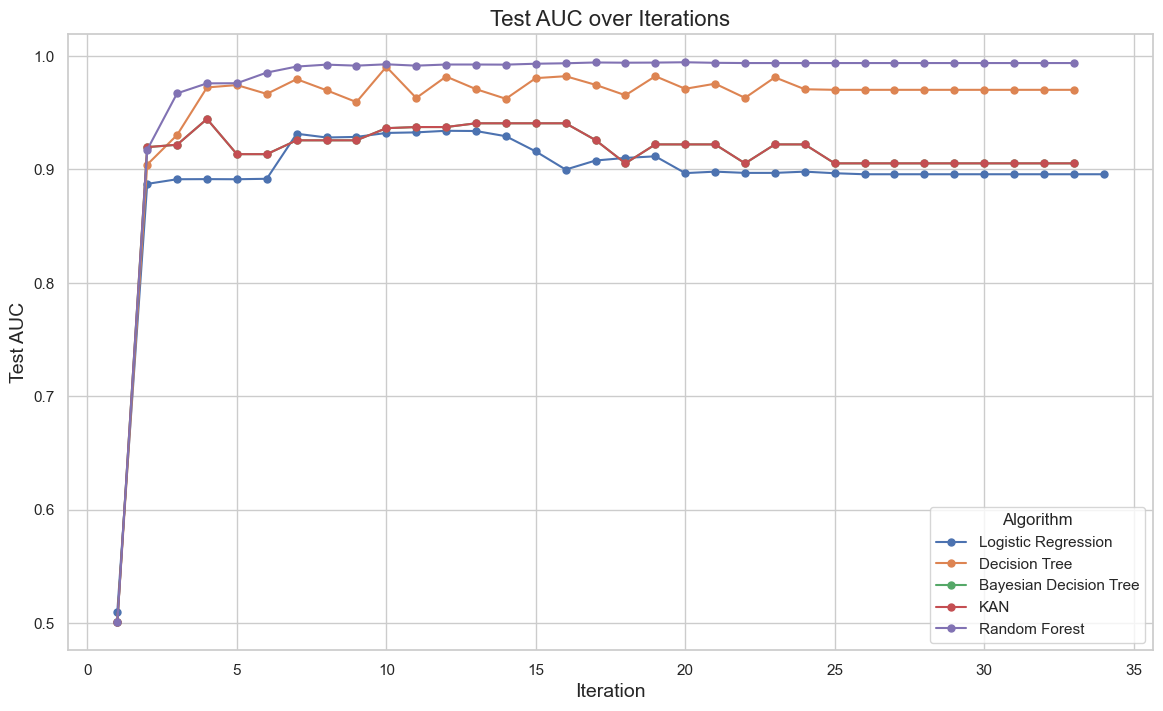

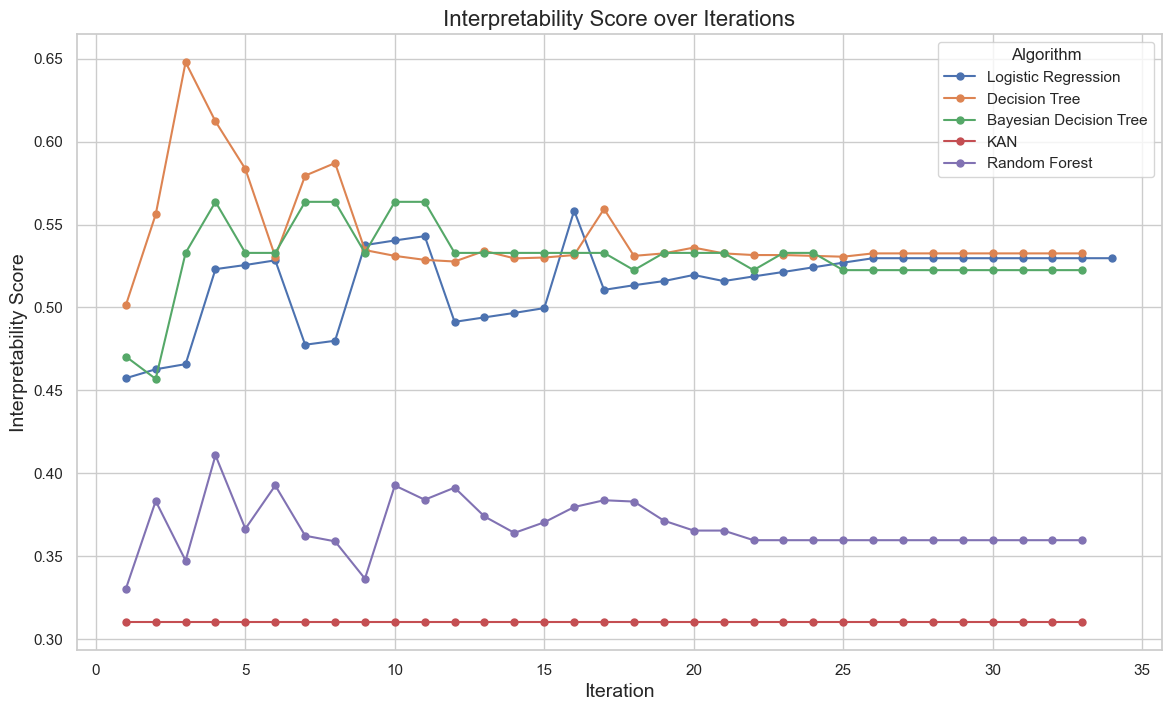

In [37]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Extract the algorithms and metrics from the results dictionary
algorithms = list(results.keys())

# Plot Test AUROC values for each algorithm
plt.figure(figsize=(14, 8))
for algo in algorithms:
    auc_length = len(results[algo]['test_auc'])  
    iterations = list(range(1, auc_length + 1))  
    plt.plot(iterations, results[algo]['test_auc'], label=algo, marker='o', linestyle='-', markersize=5)

plt.title('Test AUC over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Test AUC', fontsize=14)
plt.legend(title='Algorithm', loc='best')
plt.grid(True)
plt.show()

# Plot Interpretability Score values for each algorithm
plt.figure(figsize=(14, 8))
for algo in algorithms:
    interp_length = len(results[algo]['interpretability_score'])  
    iterations = list(range(1, interp_length + 1))  
    plt.plot(iterations, results[algo]['interpretability_score'], label=algo, marker='o', linestyle='-', markersize=5)

plt.title('Interpretability Score over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Interpretability Score', fontsize=14)
plt.legend(title='Algorithm', loc='best')
plt.grid(True)
plt.show()
